In [63]:
import fitz
import cv2
import csv
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [64]:
pdf_document = "./PDF/Test.pdf"
doc = fitz.open(pdf_document)
for page_number in range(doc.page_count):
    page = doc[page_number]
    pix = page.get_pixmap()
    pix.save(f"page_{page_number + 1}.png")


In [65]:
# Read image
img = cv2.imread('./page_1.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



In [66]:
def is_contour_bad(c, min_area=0.5):
    """
    Determina si un contorno es "malo" basado en su tamaño y si está cerrado.

    Parámetros:
    - c: Contorno que se va a analizar.
    - min_area: Área mínima para considerar un contorno como "bueno".

    Retorna:
    - True si el contorno es "malo" (pequeño o no cerrado).
    - False si el contorno es "bueno" (suficientemente grande y cerrado).
    """
    # Calcular el área del contorno
    area = cv2.contourArea(c)
    
    # Verificar si el contorno es muy pequeño
    if area < min_area:
        return True  # Es "malo" si el área es menor que el mínimo
    
    # Verificar si el contorno es cerrado (convexo)
    if cv2.isContourConvex(c):  # Si no es convexo, lo consideramos "malo"
        return True

    # Si pasa ambas condiciones, el contorno es "bueno"
    return False


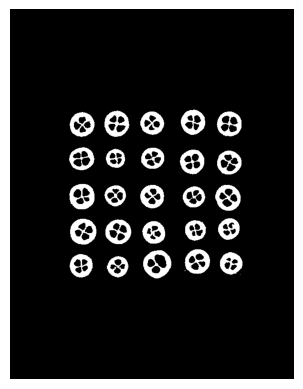

In [58]:
# Convertir a escala de grises si no está ya
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Umbral automático con Otsu
_, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


plt.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()





In [67]:
# Detectar contornos (modo TREE para jerarquía, sin filtrar)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convertir la jerarquía a un arreglo para facilitar el acceso
hierarchy = hierarchy[0]  # La jerarquía viene en un arreglo anidado


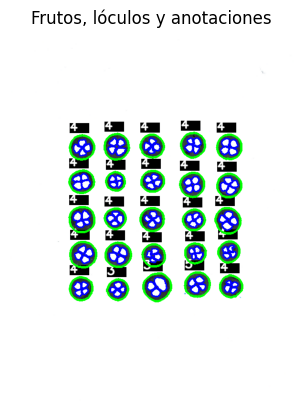

Imagen anotada guardada en: frutos_loculos_anotados.png


In [73]:
# Detectar frutos (contornos externos) y sus lóculos
fruit_locus_map = {}  # Diccionario para mapear frutos y sus lóculos
for i in range(len(contours)):
    # Identificar contornos externos (frutos)
    if hierarchy[i][3] == -1:  # Sin padre => es un fruto
        fruit_locus_map[i] = []  # Inicializar lista de lóculos para este fruto

    # Si tiene un padre, es un lóculo
    elif hierarchy[i][3] != -1:  # Tiene un padre => es un lóculo
        parent_index = hierarchy[i][3]  # Índice del fruto (padre)
        if parent_index in fruit_locus_map:
            fruit_locus_map[parent_index].append(i)  # Asociar lóculo al fruto

# Filtrar contornos padres sin lóculos
filtered_fruit_locus_map = {
    fruit_idx: loculi
    for fruit_idx, loculi in fruit_locus_map.items()
    if len(loculi) > 0  # Mantener solo los frutos con lóculos internos
}

# Filtrar lóculos con área 0
final_fruit_locus_map = {}
for fruit_idx, loculi in filtered_fruit_locus_map.items():
    # Filtrar lóculos cuyo área sea mayor a 0
    filtered_loculi = [loculus_idx for loculus_idx in loculi if cv2.contourArea(contours[loculus_idx]) > 1]
    
    # Solo agregar frutos si tienen lóculos válidos
    if len(filtered_loculi) > 0:
        final_fruit_locus_map[fruit_idx] = filtered_loculi


# Dibujar frutos y sus lóculos
image_with_contours = img.copy()

for fruit_idx, loculi in final_fruit_locus_map.items():
    # Dibujar contorno del fruto
    cv2.drawContours(image_with_contours, contours, fruit_idx, (0, 255, 0), 3)

    # Dibujar contornos de los lóculos asociados al fruto
    for loculus_idx in loculi:
        cv2.drawContours(image_with_contours, contours, loculus_idx, (255, 0, 0), 2)
    
    # Obtener la posición del fruto para anotar el número de lóculos
    x, y, w, h = cv2.boundingRect(contours[fruit_idx])  # Coordenadas del rectángulo delimitador
    num_loculi = len(loculi)  # Número de lóculos asociados
    
    # Asegurarse de que la posición del texto esté dentro de los límites de la imagen
    text_x = x
    text_y = max(y - 10, 20)  # Si y-10 es menor a 0, ajustar a 20
    
    # Dibuja un rectángulo como fondo del texto para mayor visibilidad
    cv2.rectangle(image_with_contours, (text_x, text_y - 15), (text_x + 40, text_y + 5), (0, 0, 0), -1)

    # Anotar el número de lóculos encima del fruto
    cv2.putText(
        image_with_contours,
        f"{num_loculi}",  # Texto a mostrar (número de lóculos)
        (x, y - 10),  # Posición del texto (encima del fruto)
        cv2.FONT_HERSHEY_SIMPLEX,  # Fuente del texto
        0.8,  # Tamaño de la fuente
        (255, 255, 255),  # Color del texto (blanco)
        2,  # Grosor del texto
        cv2.LINE_AA  # Tipo de línea
    )

# Mostrar la imagen con frutos, lóculos y anotaciones
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Frutos, lóculos y anotaciones")
plt.axis('off')
plt.show()

# Guardar la imagen anotada
output_path = "frutos_loculos_anotados.png"
cv2.imwrite(output_path, image_with_contours)
print(f"Imagen anotada guardada en: {output_path}")


In [74]:
# Contar frutos (contornos externos)
fruit_count = 0
for i in range(len(contours)):
    if hierarchy[i][3] == -1:  # Sin padre => es un fruto
        fruit_count += 1

# Imprimir el número de frutos detectados
print(f"Número total de frutos detectados: {fruit_count}")

Número total de frutos detectados: 27


In [75]:
# Save locule statistics
# Crear una lista para almacenar los datos
results = []

# Procesar `fruit_locus_map` y calcular métricas adicionales para cada fruto
for fruit_id, loculi in filtered_fruit_locus_map.items():  # Usar `fruit_id` directamente de las claves del diccionario
    # Calcular el número de lóculos
    n_locules = len(loculi)

    # Calcular métricas (mean, SD, CV) si hay lóculos
    if loculi:
        locule_areas = [cv2.contourArea(contours[locule]) for locule in loculi]
        locule_mean = np.mean(locule_areas)
        locule_sd = np.std(locule_areas, ddof=1)
        locule_cv = (locule_sd / locule_mean) * 100 if locule_mean != 0 else 0
    else:
        locule_mean = 0
        locule_sd = 0
        locule_cv = 0

    # Obtener la posición del fruto a partir del índice en `fruit_id`
    # Convertir el fruit_id a un índice si es necesario o usa directamente el índice correspondiente
    index = fruit_id  # Usar directamente fruit_id como índice
    x, y, w, h = cv2.boundingRect(contours[index])  # Obtener las coordenadas de posición


    # Agregar los datos a la lista de resultados
    results.append({
        "ID_Fruit": fruit_id,  # Usar el ID original
        "N_Locules": n_locules,
        "Mean_Area": locule_mean,
        "SD_Area": locule_sd,
        "CV_Area": locule_cv,
        "Position_X": x,
        "Position_Y": y
    })

# Definir el nombre del archivo CSV de salida
output_csv = "numero_loculos_y_posicion_por_fruto.csv"

# Guardar los resultados en un archivo CSV
with open(output_csv, mode="w", newline="") as file:
    # Crear un escritor de CSV con los encabezados definidos
    writer = csv.DictWriter(file, fieldnames=["ID_Fruit", "N_Locules", "Mean_Area", "SD_Area", "CV_Area", "Position_X", "Position_Y"])
    
    # Escribir la fila de encabezado (columnas) en el archivo CSV
    writer.writeheader()
    
    # Escribir las filas de datos en el archivo
    writer.writerows(results)

# Imprimir un mensaje de confirmación
print(f"Resultados guardados en: {output_csv}")


Resultados guardados en: numero_loculos_y_posicion_por_fruto.csv


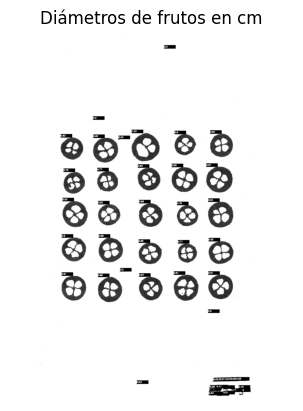

Imagen anotada guardada en: frutos_diametro_cm_anotados.png


In [80]:
# Definir la resolución en DPI (ajusta según la imagen)
dpi = 600  # Cambia este valor si tu resolución es diferente
pixels_per_cm = dpi / 2.54  # Píxeles por cm

# Dibujar frutos y anotar únicamente el diámetro en cm
image_with_contours = img.copy()

for fruit_idx, loculi in fruit_locus_map.items():
    # Obtener la posición del fruto y su ancho
    x, y, w, h = cv2.boundingRect(contours[fruit_idx])  # Coordenadas del rectángulo delimitador

    # Convertir el ancho del fruto a centímetros y redondear a dos decimales
    width_cm = round(w / pixels_per_cm, 2)

    # Asegurarse de que la posición del texto esté dentro de los límites de la imagen
    text_x = x
    text_y = max(y - 10, 10)  # Si y-10 es menor a 0, ajustar a 10

    # Dibuja un rectángulo como fondo del texto para mayor visibilidad
    cv2.rectangle(image_with_contours, (text_x, text_y - 20), (text_x + 100, text_y + 10), (0, 0, 0), -1)

    # Anotar únicamente el diámetro (ancho del fruto) en cm
    cv2.putText(
        image_with_contours,
        f"{width_cm}",  # Mostrar solo el número redondeado en cm
        (text_x, text_y),  # Posición del texto
        cv2.FONT_HERSHEY_SIMPLEX,  # Fuente del texto
        0.6,
        (255, 255, 255),  # Color del texto (blanco)
        2,  # Grosor del texto
        cv2.LINE_AA  # Tipo de línea
    )

# Mostrar la imagen con frutos y diámetros en cm anotados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Diámetros de frutos en cm")
plt.axis('off')
plt.show()

# Guardar la imagen anotada
output_path = "frutos_diametro_cm_anotados.png"
cv2.imwrite(output_path, image_with_contours)
print(f"Imagen anotada guardada en: {output_path}")


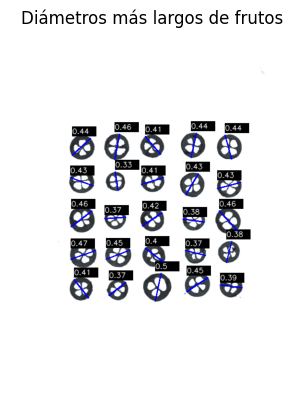

Imagen anotada guardada en: frutos_diametro_largo_anotados.png


In [179]:
# Dibujar frutos con el diámetro más largo y anotarlo
image_with_contours = img.copy()

for fruit_idx, loculi in fruit_locus_map.items():
    # Obtener los puntos del contorno del fruto
    contour = contours[fruit_idx]
    
    # Encontrar la distancia máxima entre dos puntos del contorno (diámetro más largo)
    max_dist = 0
    start_point = (0, 0)
    end_point = (0, 0)
    for i in range(len(contour)):
        for j in range(i + 1, len(contour)):
            dist = cv2.norm(contour[i][0] - contour[j][0])  # Calcular la distancia entre puntos
            if dist > max_dist:
                max_dist = dist
                start_point = tuple(contour[i][0])
                end_point = tuple(contour[j][0])

    # Convertir el diámetro a cm y redondear
    diameter_cm = round(max_dist / pixels_per_cm, 2)

    # Dibujar la línea del diámetro más largo
    cv2.line(image_with_contours, start_point, end_point, (255, 0, 0), 2)  # Línea azul de grosor 2

    # Anotar el diámetro encima del fruto
    text_x = min(start_point[0], end_point[0])  # Elegir la coordenada x menor para colocar el texto
    text_y = min(start_point[1], end_point[1]) - 10  # Ajustar para colocar encima
    text_y = max(text_y, 10)  # Asegurarse de que el texto no salga de la imagen
    cv2.rectangle(image_with_contours, (text_x, text_y - 15), (text_x + 50, text_y + 5), (0, 0, 0), -1)  # Fondo negro
    cv2.putText(
        image_with_contours,
        f"{diameter_cm}",  # Texto con el diámetro en cm
        (text_x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,  # Tamaño de la fuente
        (255, 255, 255),  # Color del texto (blanco)
        1,  # Grosor de la fuente
        cv2.LINE_AA
    )

# Mostrar la imagen con frutos y diámetros más largos anotados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Diámetros más largos de frutos")
plt.axis('off')
plt.show()

# Guardar la imagen anotada
output_path = "frutos_diametro_largo_anotados.png"
cv2.imwrite(output_path, image_with_contours)
print(f"Imagen anotada guardada en: {output_path}")
